# PBGI: this‑round vs next‑round
Illustration notebook – produces the figure showing when the classic *this‑round* rule stops too early while our *next‑round* look‑ahead avoids that. Feel free to play around with different seeds. 


In [67]:
import torch, numpy as np, matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.kernels import ScaleKernel, MaternKernel

torch.set_default_dtype(torch.double)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/opt/miniconda3/envs/stopping_rule/lib/python3.12/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


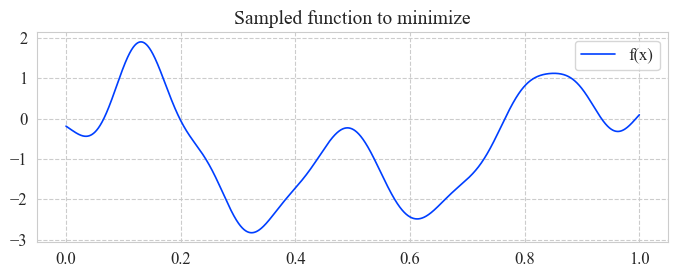

In [68]:
# --- sample a 1‑D function we will **minimize** ------------------------------
seed = 20         # try a few seeds until the two rules differ nicely
torch.manual_seed(seed); np.random.seed(seed)
granularity = 10001 

noise = 1e-6
kernel = MaternKernel(nu=2.5).double()
kernel.lengthscale = torch.tensor([[0.1]])
kernel = ScaleKernel(kernel).double()
kernel.outputscale = torch.tensor([[1]])

model0 = SingleTaskGP(torch.zeros(1,1), torch.zeros(1,1),
                      likelihood=FixedNoiseGaussianLikelihood(noise=torch.tensor([noise])), covar_module=kernel)

from botorch.sampling.pathwise import draw_kernel_feature_paths
feature_path = draw_kernel_feature_paths(model0, sample_shape=torch.Size([1]))

def f_true(x):            # ground‑truth objective (unknown to optimiser)
    return feature_path(x.unsqueeze(0)).squeeze(0).detach()

xs = torch.linspace(0,1,granularity).unsqueeze(-1)
with torch.no_grad():
    plt.figure(figsize=(7,3))
    plt.plot(xs, f_true(xs), lw=1.2, label='f(x)')
    plt.title('Sampled function to minimize'); plt.legend(); plt.tight_layout()


In [69]:
# uniform cost helper
def cost_uniform(x):
    return torch.ones(x.shape[:-1])


In [70]:
from pandora_automl.acquisition.stable_gittins import StableGittinsIndex
from pandora_automl.acquisition.ei_puc import ExpectedImprovementWithCost


In [71]:
def run_this_round(max_iter=50, lam=0.01):
    # two‑point init
    X = torch.tensor([[0.25],[0.75]])
    Y = f_true(X)
    for t in range(max_iter):
        gp = SingleTaskGP(X, Y.unsqueeze(-1),
                          likelihood=FixedNoiseGaussianLikelihood(noise=torch.ones_like(Y)*noise))
        acq = StableGittinsIndex(model=gp, maximize=False, lmbda=lam, cost=cost_uniform)
        grid = torch.linspace(0,1,granularity).unsqueeze(-1)
        vals = acq(grid.unsqueeze(1))
        x_next = grid[vals.argmin()].unsqueeze(0)     # minimise ⇒ pick *smallest* index
        y_next = f_true(x_next)
        # this‑round stop: value < index of next box
        print(y_next, vals)
        if y_next.item() < vals.min().item():
            X = torch.cat([X, x_next])
            Y = torch.cat([Y, y_next])
            break
        X, Y = torch.cat([X, x_next]), torch.cat([Y, y_next])
    best_idx = Y.argmin()
    return X, Y, best_idx


In [72]:
def run_next_round(max_iter=50, lam=0.01):
    X = torch.tensor([[0.25],[0.75]])
    Y = f_true(X)
    for t in range(max_iter):
        gp = SingleTaskGP(X, Y.unsqueeze(-1),
                          likelihood=FixedNoiseGaussianLikelihood(noise=torch.ones_like(Y)*noise))
        acq = StableGittinsIndex(model=gp, maximize=False, lmbda=lam, cost=cost_uniform)
        # look = ExpectedImprovementWithCost(model=gp, best_f=Y.min().item(),
        #                                    maximize=False, cost=cost_uniform, unknown_cost=False)
        grid = torch.linspace(0,1,granularity).unsqueeze(-1)
        vals = acq(grid.unsqueeze(1))
        # next‑round stop: no expected improvement per cost < 0
        print (Y)
        print (vals)
        if (vals.min().item() > Y[-1].item()):
            break
        x_next = grid[vals.argmin()].unsqueeze(0)     # pick best EI per cost (minimisation)
        y_next = f_true(x_next)
        X, Y = torch.cat([X, x_next]), torch.cat([Y, y_next])
    best_idx = Y.argmin()
    return X, Y, best_idx


In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid', {
    'grid.linestyle': '--',
    'grid.alpha': 0.4
})

plt.style.use('seaborn-v0_8-bright')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['text.usetex'] = False
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 16,
    'legend.fontsize': 12,
    # 'xtick.rotation': 45,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.autolayout': False,  # we’ll call tight_layout() explicitly
})

/opt/miniconda3/envs/stopping_rule/lib/python3.12/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.8071]), std = tensor([0.4920])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/opt/miniconda3/envs/stopping_rule/lib/python3.12/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.6012]), std = tensor([0.4982])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([-0.1894]) tensor([-1.5992, -1.5990, -1.5989,  ..., -0.6330, -0.6331, -0.6333],
       grad_fn=<StableGittinsIndexFunctionBackward>)
tensor([-1.5899]) tensor([-0.1794, -0.1799, -0.1803,  ..., -0.3572, -0.3573, -0.3574],
       grad_fn=<StableGittinsIndexFunctionBackward>)
tensor([-1.1550, -0.4592])
tensor([-1.5992, -1.5990, -1.5989,  ..., -0.6330, -0.6331, -0.6333],
       grad_fn=<StableGittinsIndexFunctionBackward>)
tensor([-1.1550, -0.4592, -0.1894])
tensor([-0.1794, -0.1799, -0.1803,  ..., -0.3572, -0.3573, -0.3574],
       grad_fn=<StableGittinsIndexFunctionBackward>)
tensor([-1.1550, -0.4592, -0.1894, -1.5899])
tensor([-0.1794, -0.1797, -0.1801,  ...,  0.1574,  0.1574,  0.1575],
       grad_fn=<StableGittinsIndexFunctionBackward>)
tensor([-1.1550, -0.4592, -0.1894, -1.5899, -0.9777])
tensor([-0.1793, -0.1786, -0.1780,  ..., -5.0826, -5.0840, -5.0854],
       grad_fn=<StableGittinsIndexFunctionBackward>)


/opt/miniconda3/envs/stopping_rule/lib/python3.12/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.8484]), std = tensor([0.6402])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/opt/miniconda3/envs/stopping_rule/lib/python3.12/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.8742]), std = tensor([0.5574])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/opt/miniconda3/envs/stopping_rule/lib/python3.12/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.7133]), std = tensor([0.6356])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/opt/miniconda3/envs/stopping_rule/lib/python3.12/site-packages/botorch/mode

tensor([-1.1550, -0.4592, -0.1894, -1.5899, -0.9777,  0.0916])
tensor([-0.1793, -0.1786, -0.1779,  ...,  0.0994,  0.1005,  0.1015],
       grad_fn=<StableGittinsIndexFunctionBackward>)
tensor([-1.1550, -0.4592, -0.1894, -1.5899, -0.9777,  0.0916, -2.6211])
tensor([-0.1791, -0.1769, -0.1748,  ...,  0.1002,  0.1009,  0.1015],
       grad_fn=<StableGittinsIndexFunctionBackward>)
tensor([-1.1550, -0.4592, -0.1894, -1.5899, -0.9777,  0.0916, -2.6211, -2.7820])
tensor([-0.1790, -0.1762, -0.1733,  ...,  0.1002,  0.1009,  0.1015],
       grad_fn=<StableGittinsIndexFunctionBackward>)


/var/folders/fp/176d8bqn1f9g6qr0hx0vt6540000gn/T/ipykernel_98729/1390650293.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['This-round','Next-round'])


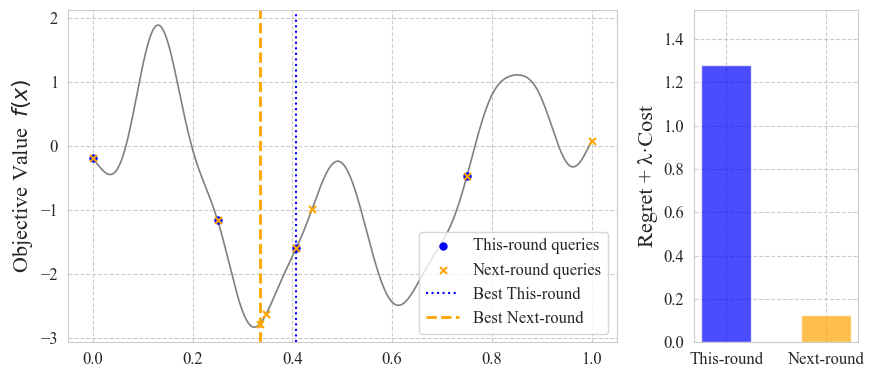

In [75]:
import matplotlib.pyplot as plt
import torch

lam = 0.01
# 1) compute true min and cost-adjusted regrets
with torch.no_grad():
    true_min = f_true(xs).min().item()

X1, Y1, best1 = run_this_round(lam=0.01)
X2, Y2, best2 = run_next_round(lam=0.01)

costs1 = cost_uniform(X1).sum().item()
costs2 = cost_uniform(X2).sum().item()

regret1 = (Y1.min().item() - true_min) + lam * costs1
regret2 = (Y2.min().item() - true_min) + lam * costs2

# 2) side-by-side plots, left panel 4× wider than right
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [4, 1.2]}) 

# Left: minimisation illustration
ax0.plot(xs, f_true(xs), lw=1.2, color='grey')
ax0.scatter(X1, f_true(X1), marker='o', c='blue', s=25, label='This-round queries', zorder=3)
ax0.scatter(X2, f_true(X2), marker='x', c='orange', s=25, label='Next-round queries', zorder=3)
#ax0.scatter(X1[best1], Y1[best1], c='blue', marker='o', s=40, label='best this-round', zorder=4)
# ax0.scatter(X2[best2], Y2[best2], c='orange',  marker='o', s=40, label='best next-round', zorder=4)
ax0.axvline(X1[best1].item(), ls=':', c='blue', lw=1.5, label='Best This-round')
ax0.axvline(X2[best2].item(), ls='--', c='orange', lw=2, label='Best Next-round')
# ax0.set_title('Minimisation: best value at stop')
# ax0.set_xlabel('Query Location $x$', fontsize=14); 
ax0.set_ylabel('Objective Value  $f(x)$')
ax0.legend(loc='lower right')

# Right: cost-adjusted regret
ax1.bar(
    ['This-round', 'Next-round'],
    [regret1, regret2],
    width=0.5, 
    alpha=0.7,
    color=['blue', 'orange'], 
)
# ax1.set_title('Cost-adjusted simple regret')
ax1.set_ylabel('Regret + λ·Cost')
ax1.set_xticklabels(['This-round','Next-round'])
ax1.set_ylim(0, max(regret1, regret2) * 1.2)
# fig.suptitle('Best Value and Cost-Adjusted Simple Regret at Stop')
plt.tight_layout()
plt.savefig("../plots/PBGI_this_round_vs_next_round.pdf")
plt.show()